In [1]:
# !pip install PIMS
# !pip install trackpy
# !pip install pandas==1.5.3
# !pip install opencv-python
# !pip install plotly

In [2]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import cv2

import matplotlib  as mpl 
import matplotlib.pyplot as plt 
import plotly.express as px

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(15, 12)) #(10, 6)
mpl.rc('image', cmap='gray')

In [3]:
# to read standard files, including tiff stacks, we can use pims.open
my_img = pims.open('tiff_series_processed_10test/*.tif')

In [4]:
my_img

<Frames>
Source: /Users/miroshni/Documents/Unifr/Unifr_work/glass_transition_in_emulsions/TrackPy/microgels/feb20/S9/tiff_series_processed_10test/*.tif
Length: 21 frames
Frame Shape: (128, 512)
Pixel Datatype: uint8

In [5]:
my_img.shape

(21, 128, 512)

In [6]:
from stardist.models import StarDist2D, Config2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [7]:
# prints a list of available models
StarDist2D.from_pretrained()

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [8]:
# define a pretrained model to segment nuclei in fluorescence images (download from pretrained)
model = StarDist2D.from_pretrained('2D_versatile_fluo') # 2D_versatile_he

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


(-0.5, 511.5, 127.5, -0.5)

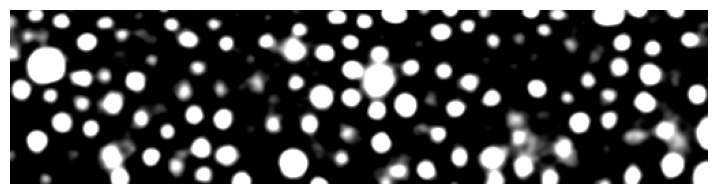

In [9]:
plt.figure(figsize=(9, 6))
plt.imshow(my_img[0], cmap='gray')
plt.axis('off')

In [10]:
@pims.pipeline
def stardist_segm(img):
#     img = cv2.resize(img, None, fx = 2, fy = 2)
    img_labels, img_details = model.predict_instances(normalize(img, 1.0, 99.8), prob_thresh=0.8, nms_thresh=0.8)
    return img_labels

In [11]:
label_image = stardist_segm(my_img)

In [12]:
label_image

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/miroshni/Documents/Unifr/Unifr_work/glass_transition_in_emulsions/TrackPy/microgels/feb20/S9/tiff_series_processed_10test/*.tif
    Length: 21 frames
    Frame Shape: (128, 512)
    Pixel Datatype: uint8

Text(0.5, 1.0, 'prediction + input overlay')

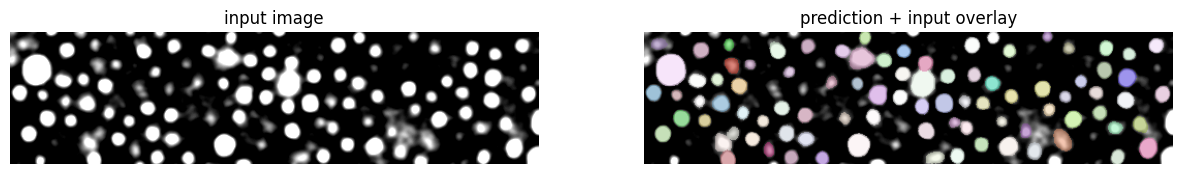

In [13]:
img_num = 9

plt.subplot(1, 2, 1)
plt.imshow(my_img[img_num], cmap='gray')
plt.axis('off')
plt.title('input image')

plt.subplot(1, 2, 2)
plt.imshow(render_label(label_image[img_num], img=my_img[img_num]))
# plt.imshow(he_labels)
plt.axis('off')
plt.title('prediction + input overlay')

In [14]:
import skimage

In [15]:
%%time
features = pd.DataFrame()

for num, img in enumerate(my_img):
    for region in skimage.measure.regionprops(label_image[num], intensity_image=img):
        # store fuatures
        dataset = pd.DataFrame({
            'y': [region.centroid[0]],
            'x': [region.centroid[1]],
            'frame': [num],
            'area': [region.area],
            'brightness': [region.intensity_mean],
        })
        
        features = pd.concat([features, dataset])
        
#         features = features.append([{'y': region.centroid[0],
#                                     'x': region.centroid[1],
#                                     'frame': num,
#                                     'area': region.area,
#                                     },])

CPU times: user 8.69 s, sys: 2.86 s, total: 11.5 s
Wall time: 1.66 s


In [16]:
features.head

<bound method NDFrame.head of              y           x  frame   area  brightness
0    51.701031  423.742268      0   97.0  190.206186
0    79.626016   95.715447      0  123.0  202.829268
0    53.485981  209.373832      0  107.0  201.429907
0    42.552000  293.408000      0  125.0  213.792000
0   107.567568  102.972973      0  148.0  213.331081
..         ...         ...    ...    ...         ...
0    27.973684   79.842105     20   76.0  114.565789
0    86.049180  349.295082     20   61.0  162.573770
0    97.140909  383.190909     20  220.0  222.709091
0    14.642857   79.857143     20   70.0  137.442857
0    62.120253  483.816456     20  158.0   70.873418

[1853 rows x 5 columns]>

In [17]:
features.to_csv('data_out/feb20_S9.csv.zip', compression='gzip', index=False)

In [18]:
# read 'features' from file 

# features = pd.read_csv('data_out/feb20_S2.csv.zip', compression='gzip')
# features.head

In [17]:
# create copy of features to make modifications
features_modif = features.copy()

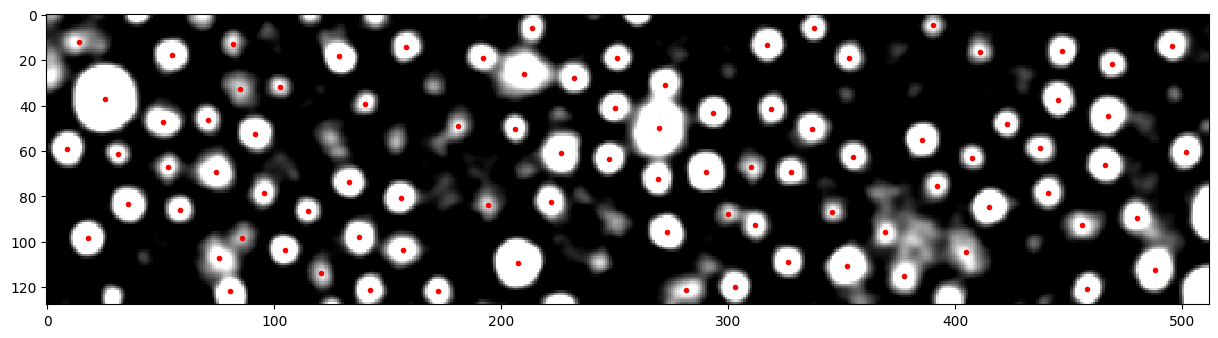

In [18]:
tp.annotate(features_modif[features_modif.frame==(9)], my_img[9], plot_style={'markersize':2});


In [19]:
# plot object areas to investigate the distribution. You can further filter out objects based on size or intensity. Not

fig = px.histogram(features_modif['area'], nbins=20, template="simple_white")

fig.show()

In [20]:
# filter out by area (make the histogram looks more or less normal distrubution)

features_modif = features_modif.loc[(features_modif['area'] > 60) & (features_modif['area'] < 299)]

In [21]:
# plot new histogram

fig = px.histogram(features_modif['area'], nbins=20, template="simple_white")

fig.show()

In [22]:
# plot the brightness (called as 'mass' in trackpy)

fig = px.histogram(features_modif['brightness'], nbins=20, template="simple_white")

fig.show()

In [23]:
# filter out by intensity, then give it the name feature as it was originally

features_modif = features_modif.loc[(features_modif['brightness'] > 150)]

In [24]:
# plot the brightness (called as 'mass' in trackpy)

fig = px.histogram(features_modif['brightness'], nbins=20, template="simple_white")

fig.show()

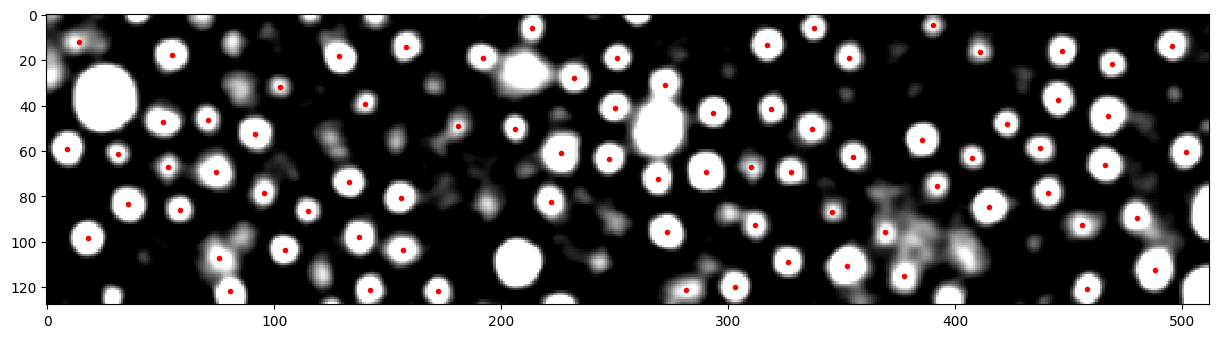

In [25]:
tp.annotate(features_modif[features_modif.frame==(9)], my_img[9], plot_style={'markersize':2});

In [26]:
# Bubble tracking
# we must specify a maximum displacement, the farthest an object can travel between frames (search_range)
# We allow for the possibility that an object might be missed for a few frames and then
# Memory keeps track of disappeared objects and maintains their ID for up to some number
# Here we use 5 frames.
# Note that the term particle refers to an object of interest.

search_range = 10
t = tp.link_df(features_modif, search_range, memory=5) # memory=5
t.head

Frame 20: 79 trajectories present.


<bound method NDFrame.head of             y           x  frame   area  brightness  particle
0   51.701031  423.742268      0   97.0  190.206186         0
0   93.120567  373.056738      0  141.0  194.205674         1
0   22.643836  354.027397      0   73.0  191.356164         2
0   32.942675  270.414013      0  157.0  216.337580         3
0   50.090909   52.381818      0  165.0  216.624242         4
..        ...         ...    ...    ...         ...       ...
0   96.200000  138.240000     20  200.0  219.700000        62
0   89.708738  114.611650     20  103.0  208.330097        20
0   29.684524  231.363095     20  168.0  218.630952        71
0   96.210256  270.107692     20  195.0  219.835897        67
0   97.140909  383.190909     20  220.0  222.709091       100

[1639 rows x 6 columns]>

In [27]:
img.shape

(128, 512)

In [28]:
(img.shape[1], img.shape[0])

(512, 128)

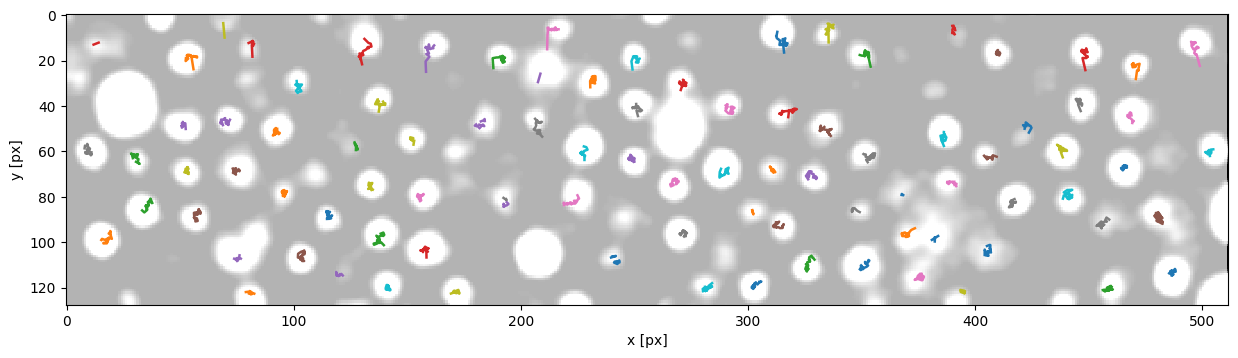

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [29]:
# plot trajectories

overlay = img.copy()
cv2.rectangle(overlay, (0, 0), (img.shape[1]-2, img.shape[0]), (255, 255, 255), -1)  # A filled rectangle
alpha = 0.7  # Transparency factor.
img_bkgr = cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)

tp.plot_traj(t, superimpose=img_bkgr, plot_style={'linewidth': 1.8}) # remove the superimpose part to just plot the trajectories

In [32]:
# is there an overall drift? If so, we need to correct for it
drift = tp.compute_drift(t)

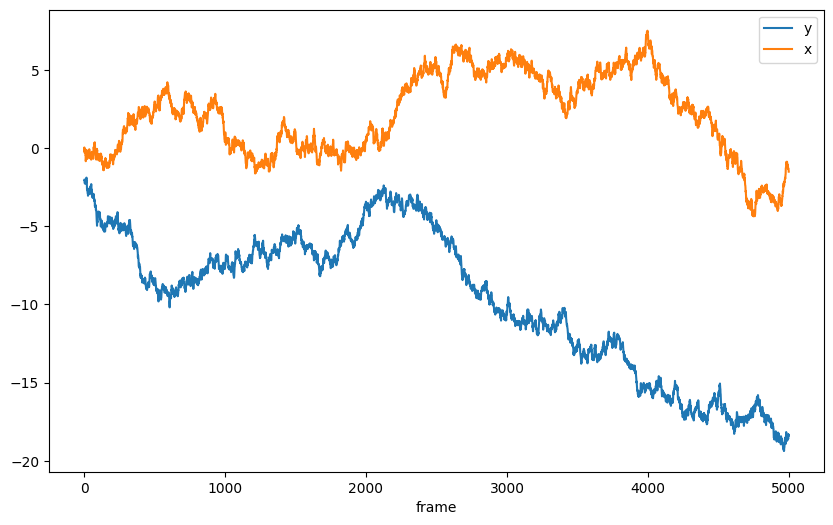

In [33]:
drift.plot(figsize=(10, 6)) # if there is a horizontal line, there is no drift
plt.show()

In [34]:
# correct drift
t_corrected = tp.subtract_drift(t.copy(), drift)

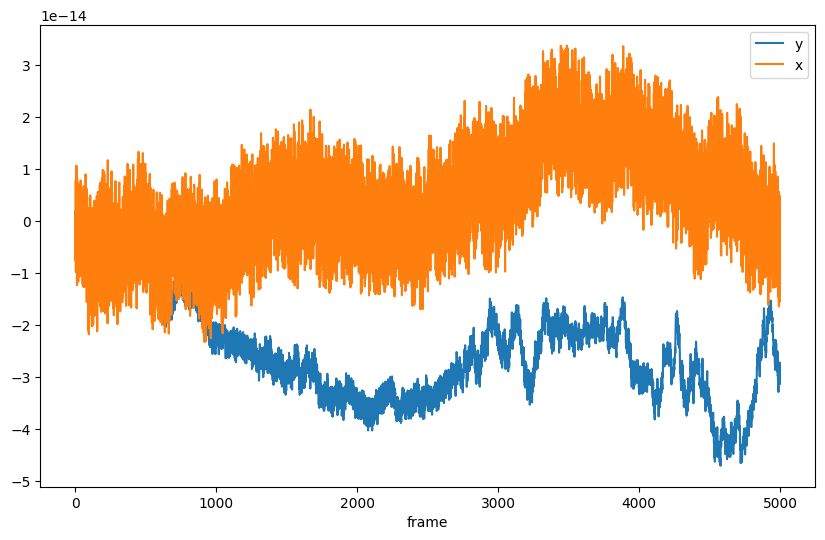

In [35]:
# plot drift plots one more to be sure it works well
drift = tp.compute_drift(t_corrected)

drift.plot(figsize=(10, 6)) # if there is a horizontal line, there is no drift
plt.show()

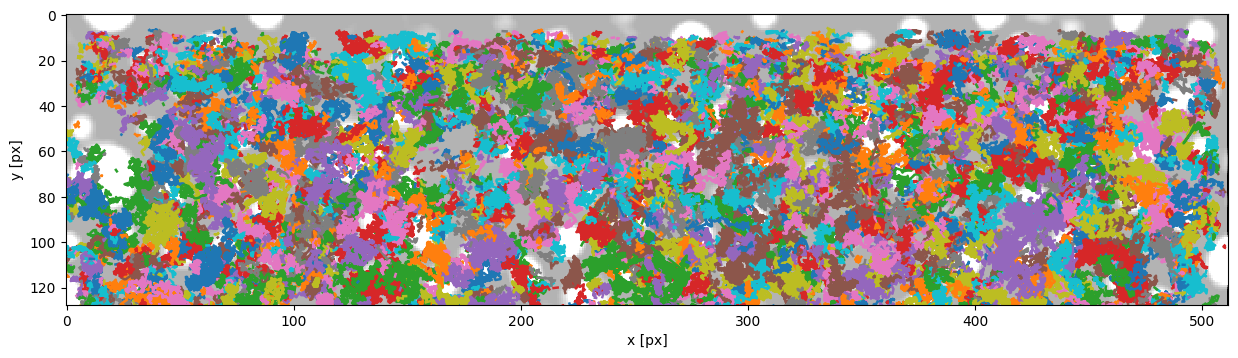

In [49]:
overlay = img.copy()
cv2.rectangle(overlay, (0, 0), (img.shape[1]-2, img.shape[0]), (255, 255, 255), -1)  # A filled rectangle
alpha = 0.7  # Transparency factor.
img_bkgr = cv2.addWeighted(overlay, alpha, img, 1-alpha, 0)

ax = tp.plot_traj(t_corrected, superimpose=img_bkgr, plot_style={'linewidth': 1.8})
plt.show()

In [37]:
t_corrected.to_csv('data_out/feb20_S9_t_corrected.csv', index=False)

In [38]:
# compute the mean squared displacement (MSD) of each particle using the imsd function, and plot MSD vs. lag time
# im = tp.imsd(t_corrected, 0.11073, 62.2, max_lagtime=622) # microns per pixel = 0.3069 (from Nikon reader (footer of the main window)), frames per second = 1.0 (1 frame per about 1 sec)

In [39]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(im.index, im, 'k-', alpha=0.1) # black lines, semitransparent
# ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
# ax.set_xscale('log')
# ax.set_yscale('log')

In [40]:
# Ensemble Mean Squared Displacement

# !!! This doesn't work for the latest pandas version (2.0.3). Downgrade version to 1.5.3 (pip install pandas==1.5.3)

em = tp.emsd(t_corrected, 0.06905, 120., max_lagtime=5000)
# em = tp.emsd(t_corrected, 0.11073, 62.2, max_lagtime=622)

/Users/miroshni/anaconda3/lib/python3.11/site-packages/trackpy/motion.py:235: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().

/Users/miroshni/anaconda3/lib/python3.11/site-packages/trackpy/motion.py:236: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().



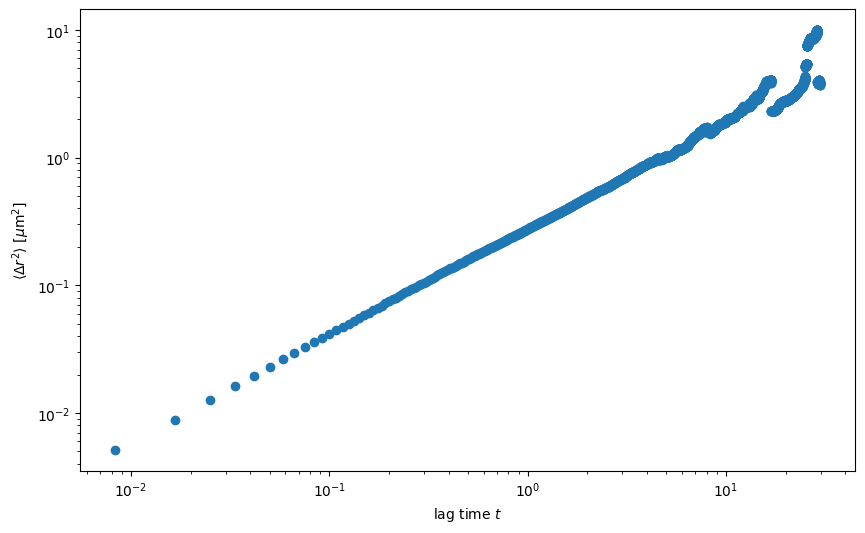

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(im.index, im, 'o', color='red')
ax.plot(em.index, em, 'o')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
      xlabel='lag time $t$')
# ax.set_ylim(0.1, 100)
ax.set_xscale('log')
ax.set_yscale('log')

In [42]:
em.head

<bound method NDFrame.head of lagt
0.008333     0.005124
0.016667     0.008888
0.025000     0.012545
0.033333     0.016155
0.041667     0.019647
               ...   
29.716667    3.702259
29.725000    3.673090
29.733333    3.708592
29.741667    3.772024
29.750000    4.011205
Name: msd, Length: 3570, dtype: float64>

In [43]:
# write MSD in file

import csv

with open('data_out/feb20_S9_EMSD.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)#, delimiter='\t')
    writer.writerow(["lag time t", "dr^2"])
    writer.writerows(zip(em.index, em))

In [44]:
# Fit this ensemble mean-squared displacement to a power law. Linear regression in log space

# plt.figure(figsize=(10, 6))
# plt.ylabel=(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
# plt.xlabel=('lag time $t$')
# tp.utils.fit_powerlaw(em) #performs linear best fit in log space, plots

In [45]:
# test how dataframe 't_corrected' was written to file 

# f_corr = pd.read_csv('data_out/BE4-2D_4000frames/BE4-2D_t_corrected.csv')
# f_corr.head

In [46]:
# NOT corrected Ensemble Mean Squared Displacement

# em_notcor = tp.emsd(t, 0.3069, 1.0, max_lagtime=4000)

In [47]:
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(em_notcor.index, em_notcor, 'o')
# ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
# # ax.set_ylim(0.1, 100)
# ax.set_xscale('log')
# ax.set_yscale('log')